In [1]:
import sys
from pathlib import Path

# Notebook ka folder
NOTEBOOK_DIR = Path().resolve()

# Project root = parent folder
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Add project root to import path
sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)


Project root: D:\Langchain_LangGraph_03-12-2025\MyProject


In [2]:
#now importing all the Module which is used to build the AI Model.
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate
from exception import CustomException
from logger_config import logger
import os,sys

#using openai chat model and embedding models
from langchain_openai import ChatOpenAI,OpenAIEmbeddings

#using groq chat model 
from langchain_groq import ChatGroq

#using open source chat model from hugging Face
from langchain_huggingface import ChatHuggingFace,HuggingFaceEmbeddings,HuggingFaceEndpoint

from config import *

from langchain_core.runnables import RunnableBranch,RunnableLambda,RunnableParallel,RunnableSequence,RunnablePassthrough

[2025-12-06 21:43:17,165]-config_variable.py-INFO -Loading the environment Variable
[2025-12-06 21:43:17,168]-config_variable.py-INFO -Environment Variable successfully Loaded


In [3]:
%pwd

'd:\\Langchain_LangGraph_03-12-2025\\MyProject\\notebooks'

In [4]:
#import Langgraph related Modules
import langgraph
from langgraph.graph import StateGraph,START,END
from dataclasses import dataclass
from typing import TypedDict
from typing import Literal,List,Annotated
from langchain_core.messages import AnyMessage,AIMessage,HumanMessage,ToolMessage

from pydantic import BaseModel #using this class we can perform validation to schema

from langgraph.prebuilt import tool_node,tools_condition #in this class we put all tools together
#tools_condition wrt to tool msg it will route the flow data to ttol node to perform execution

from langchain_core.tools import tool,Tool,StructuredTool

from langgraph.graph.message import BaseMessage #this is special class which hold every mesaage init.



## step:1) defining the models components

In [5]:
model1 = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0.2 #we call as creative parameter
)
model1

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x00000236BE1B9270>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x00000236BE0ED450>, root_client=<openai.OpenAI object at 0x00000236BE327CA0>, root_async_client=<openai.AsyncOpenAI object at 0x00000236BE819120>, temperature=0.2, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [6]:
model2 = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.2 #we call as creative parameter
)
model2

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000236BF8E20B0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000236BF9189A0>, model_name='llama-3.1-8b-instant', temperature=0.2, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
llm = HuggingFaceEndpoint(  
repo_id="meta-llama/Llama-3.1-8B-Instruct",  
task="text-generation",  
max_new_tokens=512,  
do_sample=False,  
repetition_penalty=1.03,  
)  

model3 = ChatHuggingFace(llm=llm, verbose=True)
model3

ChatHuggingFace(llm=HuggingFaceEndpoint(repo_id='meta-llama/Llama-3.1-8B-Instruct', repetition_penalty=1.03, stop_sequences=[], server_kwargs={}, model_kwargs={}, model='meta-llama/Llama-3.1-8B-Instruct', client=<InferenceClient(model='meta-llama/Llama-3.1-8B-Instruct', timeout=120)>, async_client=<InferenceClient(model='meta-llama/Llama-3.1-8B-Instruct', timeout=120)>, task='text-generation'), model_id='meta-llama/Llama-3.1-8B-Instruct', model_kwargs={})

## building different type of complex workflows using LangGraph

### 1) building Conditional workflow

#### defining state or memory schema for this workflow

In [8]:
class QuadraticSchema(TypedDict):
    a : int
    b : int
    c : int
    
    quadratic_eqn : str | None
    discriminant : float | None
    
    result : str | None

In [9]:
graph = StateGraph(state_schema=QuadraticSchema)
graph

In [10]:
#using langgraph defining nodes for these workflow.
def QuadraticEqnNode(state:QuadraticSchema) ->QuadraticSchema:
    #fetching the values from state.
    a = state['a']
    b = state['b']
    c = state['c']
    
    #forming quadratic eqn based on this input.
    equation = f"{a}x2 + {b}x + {c}"
    
    #updating this eqn to the state.
    return {
        'quadratic_eqn':equation
    }

In [11]:
import numpy as np

In [12]:
def discriminantCalculationNode(state:QuadraticSchema) ->QuadraticSchema:
    #fetching the values from state.
    a = state['a']
    b = state['b']
    c = state['c']
    
    #forming quadratic eqn based on this input.
    desc = (b*b) - (4*a*c)
    
    #updating this eqn to the state.
    return {
        'discriminant':desc
    }

In [13]:
def RealrootNode(state:QuadraticEqnNode)->QuadraticEqnNode:
    desc = state['discriminant']
    a = state['a']
    b = state['b']
    c = state['c']
    
    
    root1 = (-b + np.sqrt(desc))/ (2*a)
    root2 = (-b - np.sqrt(desc))/ (2*a)
    
    result = f"the real roots are {root1} and {root2}"
    
    return {
        'result':result
    }
    

In [14]:
def RepeatRootNode(state: QuadraticEqnNode) -> QuadraticEqnNode:
    desc = state['discriminant']
    a = state['a']
    b = state['b']
    c = state['c']

    root = -b / (2 * a)

    result = (
        f"The equation has a repeated real root because the discriminant ({desc}) = 0. "
        f"The repeated root is {root}."
    )

    return {
        "result": result
    }


In [15]:
def NoRealRootNode(state: QuadraticEqnNode) -> QuadraticEqnNode:
    desc = state['discriminant']
    a = state['a']
    b = state['b']
    c = state['c']

    result = (
        f"No real roots exist because the discriminant ({desc}) is negative. "
    )

    return {
        "result": result
    }


## conditional router nodes which redirect the node based on result

In [16]:
def choose_root_node(state):
    desc = state["discriminant"]

    if desc < 0:
        return "NoRealRootNode"
    elif desc == 0:
        return "RepeatRootNode"
    else:
        return "RealrootNode"


In [17]:
#now adding node and edges to graph to form a workflow.
graph.add_node(node="QuadraticEqnNode",action=QuadraticEqnNode)
graph.add_node(node="discriminantCalculationNode",action=discriminantCalculationNode)
graph.add_node(node="RealrootNode",action=RealrootNode)
graph.add_node(node="RepeatRootNode",action=RepeatRootNode)
graph.add_node(node="NoRealRootNode",action=NoRealRootNode)

### ✔ KEY = condition function ka RETURN
    ✔ VALUE = graph ka NEXT node name
    syntax:
add_conditional_edges(source, condition_function(router fcn), path_map)
###

In [18]:
graph.add_edge(start_key=START,end_key="QuadraticEqnNode")
graph.add_edge(start_key='QuadraticEqnNode',end_key="discriminantCalculationNode")
graph.add_conditional_edges(
    "discriminantCalculationNode",     # source node
    choose_root_node,                  # condition function
    {
        "RealrootNode": "RealrootNode",
        "RepeatRootNode": "RepeatRootNode",
        "NoRealRootNode": "NoRealRootNode"
    }
)

graph.add_edge(start_key='discriminantCalculationNode',end_key=END)

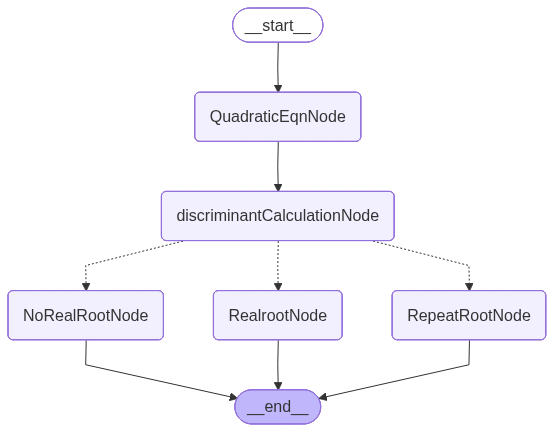

In [19]:
workflow = graph.compile()
workflow

In [20]:
#defining initial state 
state = QuadraticSchema(a=10,b=5,c=5)

response = workflow.invoke(input=state)
response

{'a': 10,
 'b': 5,
 'c': 5,
 'quadratic_eqn': '10x2 + 5x + 5',
 'discriminant': -175,
 'result': 'No real roots exist because the discriminant (-175) is negative. '}

## LLM Based Conditional Workflow

### defining the state schema for Customer Feedback

In [21]:
class FeedbackSchema(TypedDict):
    review : str
    sentiment : Literal['Positive','Negative'] | None
    result : str | None
    dignosis : dict 

In [22]:
#now defing the object of stategraph class
graph2 = StateGraph(state_schema=FeedbackSchema)
graph2

In [23]:
from pydantic import Field

In [24]:
class SentimentReviewSchema(BaseModel):
    sentiment: Annotated[
        Literal["positive", "negative"],
        Field(
            ...,
            description="Based on review show the sentiments",
            examples=["positive", "negative"]
        )
    ]

In [25]:
from langchain_core.output_parsers import StrOutputParser
parser = StrOutputParser()

### note :- if  am using structure output concept no need to explicit parser the response

In [26]:
def SentimentNode(state:FeedbackSchema)->FeedbackSchema:
    try:
        #now fetch the field from state
        review = state['review']
        
        #now converting dynamic user request to structure instruction prompt.
        prompt = PromptTemplate(
            template="""
            You are an expert sentiment classifier.

            Your task:
            - Read the following user review.
            - Determine whether the sentiment is **positive** or **negative** only.
            - Do NOT explain the reasoning.
            - Return ONLY the sentiment using the structured output schema.

            Review:
            "{review}"
            """,
            input_variables=['review']
        )
        
        #wrapping model with structure output.
        llm_str = model2.with_structured_output(schema=SentimentReviewSchema)
        
        #forming chain
        chain = prompt | llm_str
        
        
        #invoking the chain.
        result = chain.invoke(input={'review':review})
        
        logger.info(msg=f"SentimentNode and got {result} ")
        
        
        #update the state.
        return {
            'sentiment':result.sentiment
        }
    except Exception as e:
        raise CustomException(e,sys)

### here we are using router function the route the flow of data wrt condition

In [27]:
def conditionalrouterNode(state:FeedbackSchema):
    sent = state['sentiment'].lower()
    if sent == "positive":
        return "PositiveFeedbackNode"
    else:
        return "NegativeReviewDignosisNode"

In [28]:
#now defining the positive feedback Node.
def PositiveFeedbackNode(state:FeedbackSchema)->FeedbackSchema:
    
    try: 
        review = state['review']
        sent   = state['sentiment']
        
        
        prompt = PromptTemplate(
        template="""
        You are a customer support assistant.

        The sentiment of the following review has already been identified as **positive**.

        Your task:
        - Read the customer review.
        - Generate a short, polite, and customer-friendly **thank-you response**.
        - The message should be appreciative and positive.
        - Keep the response within **1–2 lines**.
        - Do NOT include analysis, bullet points, or internal details.
        - Write the response as it will be shown directly to the customer.

        Customer Review:
        "{review}"

        Detected Sentiment: "{sent}"

        Return only the final thank-you message text.
        """,input_variables=['review','sent']
        )
        
        chain = prompt | model1 | parser
        
        response = chain.invoke(input={'review':review,'sent':sent})
        
        logger.info(f"PositiveFeedbackNode and this will be feedback {response}")
        
        return {
            'result':response
        }
    except Exception as e:
        raise CustomException(e,sys)


In [29]:
# Defining the schema for negative reviews.
# This schema extracts specific information from the review such as:
# issue_type, tonality, and urgency.

In [30]:
class NegativeReviewSchema(BaseModel):
    
    issue_type: Literal[
        "payment",
        "delivery",
        "product_quality",
        "customer_service",
        "technical_issue",
        "pricing",
        "other"
    ] = Field(
        ...,
        description="Primary issue identified from the review"
    )

    tonality: Literal[
        "angry",
        "frustrated",
        "disappointed",
        "complaining",
        "threatening",
        "neutral_negative"
    ] = Field(
        ...,
        description="Emotional tone of the negative review"
    )

    urgency: Literal[
        "low",
        "medium",
        "high",
        "critical"
    ] = Field(
        ...,
        description="Urgency level based on customer language and intent"
   
    )

In [31]:
#here i am using output parser concept to enforce the llm to give response in pydantic schema or dict format mei.
from langchain_core.output_parsers import PydanticOutputParser
pydan_parser = PydanticOutputParser(pydantic_object=NegativeReviewSchema)
pydan_parser

PydanticOutputParser(pydantic_object=<class '__main__.NegativeReviewSchema'>)

In [32]:
def NegativeReviewDignosisNode(state:FeedbackSchema)-> FeedbackSchema:
    #now fetching the review key from state schema(FeedbackSchema)
    try:
        review = state['review']
        
        #now running the dignosis fetching the specific structure format out of it by using prompt template
        prompt = PromptTemplate(
                template="""
            You are an expert in customer review analysis and diagnosis.

            You are given a customer review:
            {review}

            Your task is to analyze the review and extract the following information:
            1. Identify the main issue mentioned in the review.
            2. Determine the tonality (emotional tone) of the review.
            3. Assess the urgency level based on the customer's language and intent.

            Return the response strictly in the structured format provided below.
            Do not add any extra text or explanation.

            {format_instructions}
            """,
                input_variables=["review"],
                partial_variables={
                    "format_instructions": pydan_parser.get_format_instructions()
                }
            )
        
        
        #forming a sequential chain 
        chain = prompt | model1 | pydan_parser
        
        
        #now invoking the chain to execute this task by llm.
        result = chain.invoke(input={'review':review})
        
        logger.info(f"NegativeReviewDignosisNode  and this output we got {result}")
        
        return {
            'dignosis':result.model_dump()
        }
        
    except Exception as e:
        raise CustomException(e,sys)

In [33]:
def NegativeFeedbackNode(state:FeedbackSchema)->FeedbackSchema:
    #fetching the -ve review and fetching -ve review dignosis 
    try:
        review = state['review']
        dignosis = state['dignosis']
        
        
        #dynamic user query converting into structure instruction prompt.
        prompt = PromptTemplate(
        template="""
            You are an expert customer support feedback specialist.

            The following customer review has already been classified as **negative**.

            Customer Review:
            {review}

            Diagnosis of the review:
            {dignosis}

            Based on the above diagnosis:
            - Acknowledge the customer's issue with empathy.
            - Address the identified problem clearly and professionally.
            - Respond according to the urgency level.
            - Maintain a polite, supportive, and reassuring tone.

            Generate a short, clear, and customer-friendly response message within 1-2 lines.
            Do not repeat the diagnosis details in the response.
        """,
        input_variables=["review", "dignosis"]
        )
        
        chain = prompt | model2 | parser
        
        #invoking the chain to execute the task.
        result = chain.invoke(input={'review':review,'dignosis':dignosis})
        
        logger.info(f"NegativeFeedbackNode and we got this feedback by llm {result}")
        
        return {
            'result': result
        }
    except Exception as e:
        raise CustomException(e,sys)


In [34]:
#now adding node and edges to graph.
graph2.add_node(node="SentimentNode",action=SentimentNode)
graph2.add_edge(start_key=START,end_key="SentimentNode")

graph2.add_conditional_edges(
    'SentimentNode',
    conditionalrouterNode,
    {
        "PositiveFeedbackNode":"PositiveFeedbackNode",
        "NegativeReviewDignosisNode":"NegativeReviewDignosisNode"
    }
    
)

graph2.add_node(node="PositiveFeedbackNode",action=PositiveFeedbackNode)
graph2.add_node(node="NegativeReviewDignosisNode",action=NegativeReviewDignosisNode)
graph2.add_edge(start_key="NegativeReviewDignosisNode",end_key="NegativeFeedbackNode")
graph2.add_node(node="NegativeFeedbackNode",action=NegativeFeedbackNode)

In [35]:
graph2.add_edge("PositiveFeedbackNode",END)
graph2.add_edge("NegativeFeedbackNode",END)

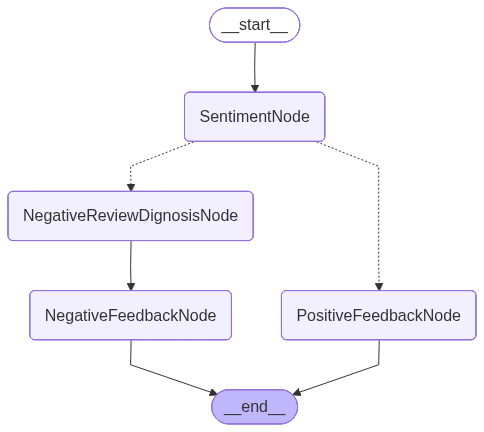

In [36]:
workflow2 = graph2.compile()
workflow2

In [37]:
#review provided by user.
text = """I bought this smartphone last month and I am really disappointed. 
The battery drains very quickly and it hardly lasts half a day. 
The camera quality is poor, especially in low light, and the pictures come out blurry. 
The phone also hangs frequently while using normal apps. Overall, it feels overpriced and I regret purchasing it."""

#review saving them to state memory.
initial_state = FeedbackSchema(review=text)

#invoking the workflow passing initial memory or stATe or sharing to throughout workflow .
response = workflow2.invoke(initial_state)
response

[2025-12-06 21:43:19,048]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
[2025-12-06 21:43:19,060]-1380235710.py-INFO -SentimentNode and got sentiment='negative' 
[2025-12-06 21:43:19,924]-_client.py-INFO -HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2025-12-06 21:43:19,937]-1457262818.py-INFO -NegativeReviewDignosisNode  and this output we got issue_type='product_quality' tonality='disappointed' urgency='high'
[2025-12-06 21:43:20,127]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
[2025-12-06 21:43:20,132]-3476809941.py-INFO -NegativeFeedbackNode and we got this feedback by llm Here's a possible response message:

"Dear valued customer, we apologize for the disappointing experience with your smartphone's battery life, camera quality, and performance. We'd be happy to assist you with a replacement or refund, and we'll expedite the process to

{'review': 'I bought this smartphone last month and I am really disappointed. \nThe battery drains very quickly and it hardly lasts half a day. \nThe camera quality is poor, especially in low light, and the pictures come out blurry. \nThe phone also hangs frequently while using normal apps. Overall, it feels overpriced and I regret purchasing it.',
 'sentiment': 'negative',
 'result': 'Here\'s a possible response message:\n\n"Dear valued customer, we apologize for the disappointing experience with your smartphone\'s battery life, camera quality, and performance. We\'d be happy to assist you with a replacement or refund, and we\'ll expedite the process to ensure you receive a resolution as soon as possible."',
 'dignosis': {'issue_type': 'product_quality',
  'tonality': 'disappointed',
  'urgency': 'high'}}

In [38]:
# review provided by user
text2 = """I purchased this smartphone a month ago and I’m extremely happy with it.
The battery easily lasts a full day even with heavy usage, and the fast charging is a big plus.
The camera quality is impressive, especially in low-light conditions, and the photos come out sharp and vibrant.
The phone runs smoothly without any lag, and the overall build quality feels premium.
Definitely worth the price and I would highly recommend it."""


In [39]:
#review saving them to state memory.
initial_state = FeedbackSchema(review=text2)

#invoking the workflow passing initial memory or stATe or sharing to throughout workflow .
response = workflow2.invoke(initial_state)
response

[2025-12-06 21:43:20,272]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
[2025-12-06 21:43:20,274]-1380235710.py-INFO -SentimentNode and got sentiment='positive' 
[2025-12-06 21:43:21,784]-_client.py-INFO -HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2025-12-06 21:43:21,796]-1771563193.py-INFO -PositiveFeedbackNode and this will be feedback Thank you for your kind words! We're thrilled to hear that you're enjoying your new smartphone.


{'review': 'I purchased this smartphone a month ago and I’m extremely happy with it.\nThe battery easily lasts a full day even with heavy usage, and the fast charging is a big plus.\nThe camera quality is impressive, especially in low-light conditions, and the photos come out sharp and vibrant.\nThe phone runs smoothly without any lag, and the overall build quality feels premium.\nDefinitely worth the price and I would highly recommend it.',
 'sentiment': 'positive',
 'result': "Thank you for your kind words! We're thrilled to hear that you're enjoying your new smartphone."}